# Price Prediction on Mercari market
## Description of Data
### Train
+ train_id	name	item_condition_id	category_name	brand_name	price	shipping	item_description

### Test
+ test_id	name	item_condition_id	category_name	brand_name	shipping	item_description

### Attributes
+ train_id or test_id - the id of the listing
+ name - the title of the listing. Note that we have cleaned the data to remove text that look like prices to avoid leakage. These removed prices are represented as [rm]
+ item_condition_id - the condition of the items provided by the seller
+ category_name - category of the listing brand_name
+ price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.
+ shipping - 1 if shipping fee is paid by seller and 0 by buyer
+ item_description - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. 20) to avoid leakage. These removed prices are represented as [rm]


## Make dataframes from tsv data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import numpy as np
test = pd.read_csv('test.tsv', sep='\t')
train = pd.read_csv('train.tsv', sep='\t')
train.iloc[0:10]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...


## Pipeline を作る。

In [2]:
train.info()
## missing data がいくつかあるね。

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [3]:
# train.isnull().any(axis=1)
# これは、各Rowを調べて、Nullがあるかどうか調べる。
null_data = train[train.isnull().any(axis=1)]
null_data_brand = train[train["brand_name"].isnull()]
null_data_category_name = train[train["category_name"].isnull()]

# item_description では普通のNullとしてmissing valueのものと、
#'No description yet' としてMissing Valueと同質のものが存在している。これは80000くらいある。
null_data_item_description = train[train["item_description"].isnull()]
# temp = len(train.loc[train['item_description'] == 'No description yet'])

## 以上を踏まえて、missing balue と 'no description yet' は 'na' にする。
trained_nonnull = train.fillna('na')
trained_nonnull.info()
trained_nonnull.loc[trained_nonnull['item_description'] == 'No description yet', 'item_description'] = 'na'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1482535 non-null object
brand_name           1482535 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482535 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


## 簡単な分析をしてみる。
### 試しにPriceはどうなってるか。

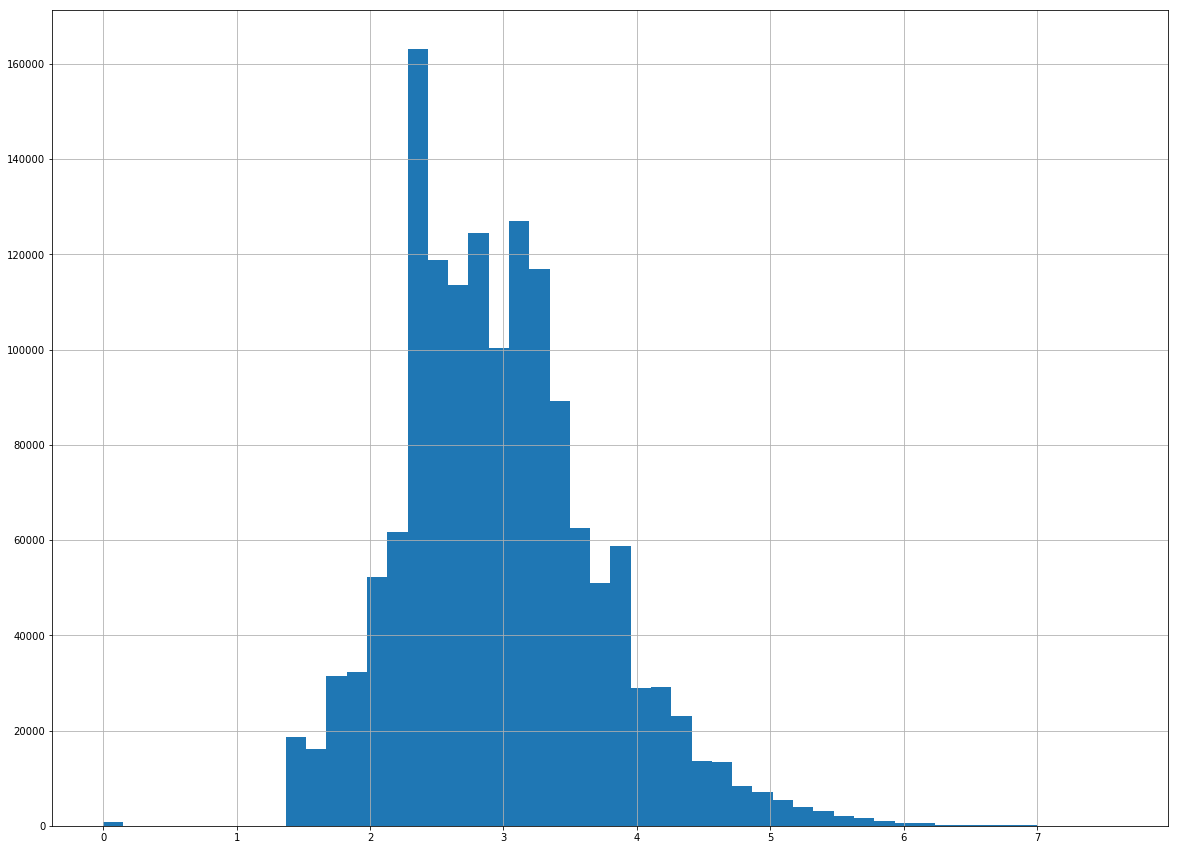

In [4]:
import matplotlib.pyplot as plt

np.log(trained_nonnull['price']+1).hist(bins=50, figsize=(20,15)) 
plt.show()

+ 外れ値的に高いやつが存在してるね、これをどうするか考える必要がある。

### 配達料がどちら持ちかでPriceは変わってくるのか？もし変わってこないなら、これはあんまり重要っぽくないね。

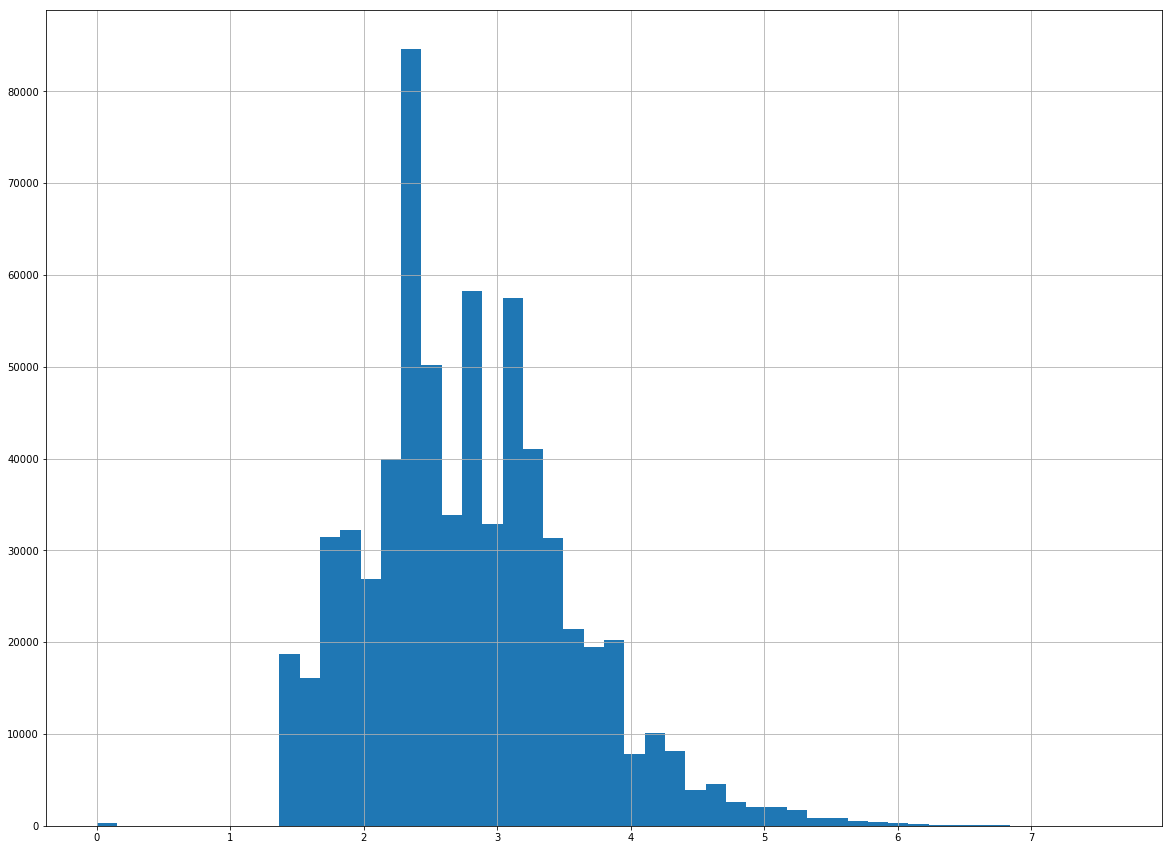

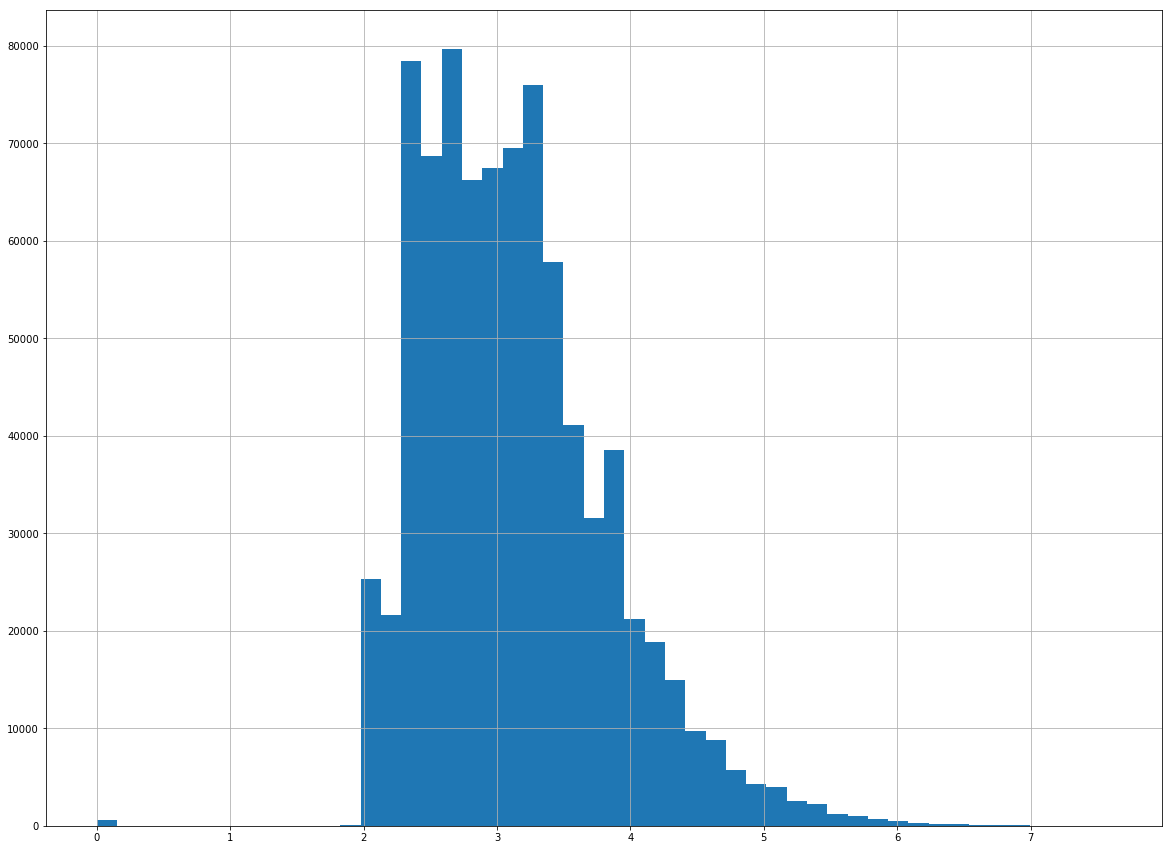

In [5]:
shipping1_train = trained_nonnull.loc[trained_nonnull['shipping'] == 1]
shipping0_train = trained_nonnull.loc[trained_nonnull['shipping'] == 0]
# dataframe は hist メソッドを持っている。
np.log(shipping1_train['price']+1).hist(bins=50, figsize=(20,15)) 
plt.show()
np.log(shipping0_train['price']+1).hist(bins=50, figsize=(20,15))
plt.show()

+ shipping = 0 すなわち、購入者が商品の配送料を支払う場合は、値段がある程度高いものになっている。ちょっと意外。

### Brand ごとに平均を出してみよう。

In [6]:
priceAndBrand = trained_nonnull[['price','brand_name']].groupby('brand_name').mean().sort_values(by='price')
priceAndBrand
# len(priceAndBrand)

,price
brand_name,
CM Style Fashion,0.000000
Gossip Girl,0.000000
DUO,3.000000
Revlon Colorsilk,3.000000
Play MG,3.000000
AA Aquarium,3.000000
Scunci,3.000000
A.B.S. by Allen Schwartz,3.000000
Old Glory,3.000000


+ 結構Brandの種類が多くてたいへんだ。

### 商品の状態ごとの平均も出してみよう。

In [7]:
trained_nonnull[['price','item_condition_id']].groupby('item_condition_id').mean().sort_values(by='price')

,price
item_condition_id,
4,24.349212
1,26.486967
3,26.540711
2,27.563225
5,31.703859


+ あんまり item-condition_id は関係ないのかな。

### カテゴリーを層でわける。

In [8]:
# category_name は、str だが、/で組み込まれた階層になっているようだ。
# Men/Tops/T-shirts , Women/Tops & Blouses/Blouse のように。
# これを反映させたようなcolumn を作っていった方がいいとおもう。これらの要素間の距離は一定じゃないので、One-hotとかはやらない方がいいだろう。
# 普通のRegression （OLS）では、サンプル間のIndependenceを仮定している。おそらく、同一のグループにあるもの、
# 例えばbeautyセクションに属するデータは互いに独立ではないといえるんではないか。サンプルの独立性って結局どういうことだっけ。OLsで仮定している独立性とは、
# Hierarchical liner regression を試す。

trained_nonnull['category_name']

# 一番深い階層は何層なのか調べる。
maxdrilldown = 0
for category in trained_nonnull['category_name']:
    numberOfDrillDown = category.count('/')
    if maxdrilldown < numberOfDrillDown:
        maxdrilldown = numberOfDrillDown
# maxdrilldown -> 4 （つまり、5層あるということ、）
'''
for i in trained_nonnull['category_name']:
    if i.count('/')==4:
        print i
'''
# Electronics/Computers & Tablets/iPad/Tablet/eBook Readers が一番深い層



"\nfor i in trained_nonnull['category_name']:\n    if i.count('/')==4:\n        print i\n"

In [9]:
def cat_split(row):
    text = row
    depth = text.count('/')+1
    txts = text.split('/')
    # 5 は maxdepth
    for i in range(0,5-depth):
        txts.append('na')
    return txts 
        
trained_nonnull["cat_1"], trained_nonnull["cat_2"], trained_nonnull["cat_3"], \
trained_nonnull['cat_4'],trained_nonnull['cat_5'] = zip(*trained_nonnull['category_name'].apply(lambda val: cat_split(val)))

In [10]:
trained_nonnull_category = trained_nonnull
trained_nonnull_category[:3]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3,cat_4,cat_5
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,na,10.0,1,na,Men,Tops,T-shirts,na,na
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,na,na
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,na,na


## ここから、ブランドを数字でラベリングする。

In [11]:
trained_nonnull_category_labeled = trained_nonnull_category.copy()
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
mydata_cat = trained_nonnull_category_labeled['brand_name']
mydata_cat_encoded = encoder.fit_transform(mydata_cat)
trained_nonnull_category_labeled['brand_name'] = mydata_cat_encoded
# これだと na も他のBrandといっしょにエンコードされてるけど、とりあえず仕方ない。4788としてencodeされてる。

## Description や category、brand が提供されているかどうかのYes-No value を入れても良い。

## Description や Product Name になんらかのFeature Engineeringをしてやりたい。
### tf-idf 値をそれぞれのrow ごとに、description と Product Name に応じて出してやる。
+ 他にもそれぞれの単語を数字で置き換えるとかも考えられる。

In [12]:
tf_idf_test = trained_nonnull_category_labeled.copy()
tf_idf_test

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3,cat_4,cat_5
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,4788,10.0,1,na,Men,Tops,T-shirts,na,na
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,3557,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,na,na
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,4180,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,na,na
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,4788,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,na,na
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,4788,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,na,na
5,5,Bundled items requested for Ruie,3,Women/Other/Other,4788,59.0,0,"Banana republic bottoms, Candies skirt with ma...",Women,Other,Other,na,na
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,79,64.0,0,Size small but straps slightly shortened to fi...,Women,Swimwear,Two-Piece,na,na
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,3957,6.0,1,You get three pairs of Sophie cheer shorts siz...,Sports & Outdoors,Apparel,Girls,na,na
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,3057,19.0,0,Girls Size small Plus green. Three shorts total.,Sports & Outdoors,Apparel,Girls,na,na
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,4788,8.0,0,I realized his pants are on backwards after th...,Vintage & Collectibles,Collectibles,Doll,na,na


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
# description related tf-idf features 
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
# 今はfull_tfidf もTrainデータのみでやっているが、これはTestデータも入れてやるべき。
full_tfidf = tfidf_vec.fit_transform(tf_idf_test['item_description'].values.tolist())
train_tfidf = tfidf_vec.transform(tf_idf_test['item_description'].values.tolist())

n_comp = 40
# これで、超スパースなTf-idfの次元を削減する。

svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
# 大きなtrainとtestがどっちも入っているデータに対して、svd_obj はフィットさせてやる、その後、これをtrain_tfidfに対して適応してやる。
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
    
train_svd.columns = ['svd_item_'+str(i) for i in range(n_comp)]
train_df = pd.concat([tf_idf_test, train_svd], axis=1)
tf_idf_test = train_df.copy()

In [14]:
# name related tf-idf features 
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
# 今はfull_tfidf もTrainデータのみでやっているが、これはTestデータも入れてやるべき。
full_tfidf = tfidf_vec.fit_transform(tf_idf_test['name'].values.tolist())
train_tfidf = tfidf_vec.transform(tf_idf_test['name'].values.tolist())

n_comp = 40
# これで、超スパースなTf-idfの次元を削減する。

svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
# 大きなtrainとtestがどっちも入っているデータに対して、svd_obj はフィットさせてやる、その後、これをtrain_tfidfに対して適応してやる。
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
    
train_svd.columns = ['svd_name_'+str(i) for i in range(n_comp)]
train_df = pd.concat([tf_idf_test, train_svd], axis=1)
train_df

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,...,svd_name_30,svd_name_31,svd_name_32,svd_name_33,svd_name_34,svd_name_35,svd_name_36,svd_name_37,svd_name_38,svd_name_39
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,4788,10.0,1,na,Men,Tops,...,-0.016471,-0.005978,-0.003903,-0.003544,-5.046269e-03,0.008636,-0.004962,0.002040,0.001866,-0.000570
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,3557,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,...,-0.000099,0.000100,-0.000007,0.000116,-1.900010e-05,-0.000088,-0.000013,0.000440,-0.000114,0.000308
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,4180,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,...,-0.008708,0.008966,-0.000033,0.003084,-4.184783e-04,0.002380,-0.000860,0.001862,-0.001026,-0.002204
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,4788,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,...,0.010215,0.009858,-0.002359,-0.007979,2.761890e-04,-0.007729,-0.003803,0.000590,0.001124,-0.002401
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,4788,44.0,0,Complete with certificate of authenticity,Women,Jewelry,...,-0.038715,0.042381,0.010885,0.010022,-4.487511e-03,-0.034237,-0.013915,0.058928,0.020676,-0.046010
5,5,Bundled items requested for Ruie,3,Women/Other/Other,4788,59.0,0,"Banana republic bottoms, Candies skirt with ma...",Women,Other,...,0.000236,-0.000492,-0.001233,0.000606,1.052074e-05,0.000949,0.000543,0.001096,-0.000160,-0.000872
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,79,64.0,0,Size small but straps slightly shortened to fi...,Women,Swimwear,...,-0.000057,0.000061,0.000102,-0.000143,-1.111213e-07,0.000001,0.000026,0.000015,0.000193,0.000029
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,3957,6.0,1,You get three pairs of Sophie cheer shorts siz...,Sports & Outdoors,Apparel,...,0.012803,-0.000285,-0.024613,-0.013131,-9.622567e-04,0.001552,-0.007028,-0.022109,-0.008113,0.002724
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,3057,19.0,0,Girls Size small Plus green. Three shorts total.,Sports & Outdoors,Apparel,...,0.049062,0.018135,-0.060862,-0.018767,1.182050e-03,0.051106,-0.019116,-0.035082,0.009429,-0.027532
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,4788,8.0,0,I realized his pants are on backwards after th...,Vintage & Collectibles,Collectibles,...,0.003563,-0.041455,0.012856,0.032543,-3.549043e-03,-0.040363,0.178837,-0.012943,-0.013014,-0.025042


In [15]:
train_cleaned = train_df.copy()

### とりあえず明らかにできるFeature Engineeringは終わった。ここからどんな分析が可能か、またRepresentation Learningは可能か。等みていく。
+ テキストを分析して、その特徴を抽出できるかも。
+ 高いブランドネームとかわかれば、それも役に立つかも。特徴を学べるかもね。
+ Category をもとに、hierarchical analysis ができる。

### まずこのコンテストでは、testデータにPriceが与えられていないので、自分のモデルの良さを測るため、Trainセットをtrainとtestにわけておく。（いずれ、TrainをValidationにもわける。】

In [16]:
# なにも考えずにシンプルにわけることにする。
from sklearn.model_selection import train_test_split
import numpy as np
train_set, test_set = train_test_split(train_cleaned, test_size=0.2, random_state=42)
train_set, validation_set = train_test_split(train_set, test_size=0.1, random_state=42)

In [17]:
#多分、ここでちゃんと分けれてるかもみたほうがいい。
train_set.describe()
test_set.describe()
validation_set.describe()
#Okそう。

,train_id,item_condition_id,brand_name,price,shipping,svd_item_0,svd_item_1,svd_item_2,svd_item_3,svd_item_4,...,svd_name_30,svd_name_31,svd_name_32,svd_name_33,svd_name_34,svd_name_35,svd_name_36,svd_name_37,svd_name_38,svd_name_39
count,1.186030e+05,118603.000000,118603.000000,118603.000000,118603.000000,1.186030e+05,118603.000000,118603.000000,118603.000000,118603.000000,...,118603.000000,118603.000000,118603.000000,118603.000000,118603.000000,118603.000000,118603.000000,118603.000000,118603.000000,118603.000000
mean,7.396601e+05,1.908822,3541.996231,26.836800,0.446835,5.565106e-02,0.110680,-0.024509,0.000061,0.017883,...,0.000225,0.002791,-0.003066,0.001632,-0.000257,-0.001275,0.001707,0.004084,0.001707,-0.000593
std,4.276348e+05,0.902630,1494.459766,38.782526,0.497168,2.292411e-01,0.099927,0.112924,0.093152,0.087438,...,0.049339,0.049011,0.047810,0.047891,0.046226,0.047335,0.046551,0.045901,0.045873,0.045659
min,6.000000e+00,1.000000,1.000000,0.000000,0.000000,-4.109459e-17,-0.000012,-0.595485,-0.617507,-0.475432,...,-0.436502,-0.343072,-0.455332,-0.358711,-0.610200,-0.513689,-0.259289,-0.367716,-0.204152,-0.291961
25%,3.689260e+05,1.000000,2604.000000,10.000000,0.000000,6.581864e-07,0.040737,-0.067434,-0.032965,-0.014990,...,-0.008121,-0.006216,-0.008041,-0.006282,-0.001279,-0.008451,-0.008948,-0.007833,-0.003651,-0.007031
50%,7.373220e+05,2.000000,4434.000000,17.000000,0.000000,1.280725e-06,0.090777,-0.014525,0.000665,0.010968,...,-0.000290,0.000258,-0.000250,0.000385,-0.000138,-0.000257,-0.000357,0.000764,0.000107,-0.000483
75%,1.109698e+06,3.000000,4788.000000,29.000000,1.000000,2.190962e-06,0.151962,0.004142,0.031015,0.047059,...,0.007128,0.006934,0.007153,0.005858,0.000701,0.008973,0.004862,0.008249,0.003147,0.005605
max,1.482531e+06,5.000000,4808.000000,2000.000000,1.000000,1.000000e+00,0.713786,0.606785,0.623459,0.617337,...,0.552849,0.706324,0.478180,0.562171,0.566833,0.480701,0.696902,0.540593,0.929241,0.611139


### ここで、カテゴリー値を数字に変換しておいてやる。

In [18]:
for i in range(1,6):
    cat = 'cat_'+str(i)
    encoder = LabelEncoder()
    mydata_cat = train_set[cat]
    mydata_cat_encoded = encoder.fit_transform(mydata_cat)
    train_set[cat] = mydata_cat_encoded
train_set

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,...,svd_name_30,svd_name_31,svd_name_32,svd_name_33,svd_name_34,svd_name_35,svd_name_36,svd_name_37,svd_name_38,svd_name_39
900002,900002,New! PINK Lanyard,1,Women/Women's Accessories/Wallets,4504,20.0,1,Brand new with tag Price is for 1 LANYARD Perf...,9,110,...,-0.058638,0.006071,0.066072,0.107573,-0.008638,-0.046072,-0.046648,0.000896,-0.003746,-0.002640
502231,502231,VS Pink water bottle,1,Sports & Outdoors/Exercise/Fitness accessories,4788,13.0,0,VS metal water bottle brand new,7,37,...,0.034147,-0.000970,0.000768,-0.044717,0.004262,0.020479,0.017430,-0.003050,0.006472,0.014475
1342662,1342662,VS Pink Robe,1,Beauty/Bath & Body/Bathing Accessories,4504,26.0,0,"Size M/L, BNWT. Mauve color with black polka d...",0,9,...,0.039615,0.001061,0.001990,-0.056826,0.005077,0.025414,0.022969,-0.004703,0.007056,0.017366
699388,699388,Limited edition VS PINK Fern Crew Sz L,2,Women/Sweaters/Crewneck,3221,32.0,0,Brand new never worn limited edition crew. Jus...,9,96,...,0.033463,0.003147,-0.002831,-0.036153,0.001255,-0.003780,0.032688,0.002874,0.002755,0.034651
1429801,1429801,Rue 21 flannel,1,Women/Tops & Blouses/Button Down Shirt,4799,10.0,1,New with tags Paid [rm] Size xs,9,103,...,-0.003429,0.013034,-0.006835,-0.004493,-0.000615,0.003001,-0.010685,0.007083,-0.006472,-0.023239
942010,942010,1 keychain 1 pairs pink brand new socks,1,Women/Athletic Apparel/Socks,4788,8.0,1,na,9,5,...,-0.036191,0.002734,0.045890,0.068109,-0.008233,-0.024999,-0.022695,0.007177,-0.003966,0.003613
1345456,1345456,New FreeShip Eyeliner Gel!,1,Beauty/Makeup/Eyes,4788,9.0,1,Gel Eyeliner Hurryyy!! Last one left. Brand Ne...,0,63,...,-0.006291,-0.007535,0.005082,0.000003,-0.001305,0.007235,-0.002013,-0.004745,0.000898,0.001342
1404759,1404759,Diamond black Hoodie,3,Men/Sweats & Hoodies/Hoodie,1253,20.0,0,Size small in woman's perfect condition flash ...,5,97,...,-0.042841,-0.117583,-0.176929,-0.031289,0.004649,0.077493,-0.061676,-0.023507,0.011970,0.036504
1423041,1423041,Men's baseball cut off,3,Men/Tops/Tank,4788,6.0,1,Size xl yankees men's cut off sleeve shirt,5,102,...,0.083251,0.018410,0.148800,-0.060913,-0.002217,-0.200505,-0.021302,0.130665,-0.029606,-0.099510
862981,862981,Puma GIRLS Socks,1,Women/Athletic Apparel/Socks,3228,7.0,1,These are KIDS GIRLS puma socks! Size 7-8.5!,9,5,...,0.023412,0.002010,-0.034159,-0.013132,-0.001267,0.002556,-0.005625,-0.018254,0.001838,0.002728


### 回帰に入れたりするときにいらないColumnを削って、回帰式に入れられるようなデータ・セットにする。は

In [ ]:
y_reg = np.log(train_set['price'].values + 1)
#y_reg = train_set['price'].values
X_reg = train_set.drop(['price','train_id','name','category_name','item_description'], axis=1)

### 一応消していないが、次のCELLは必要ないと思われる。

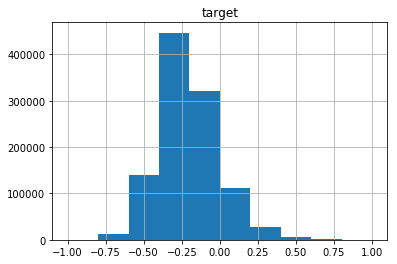

In [20]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

target_scaler = MinMaxScaler(feature_range=(-1, 1))
train_set["target"] = target_scaler.fit_transform(y_reg.reshape(-1,1))
pd.DataFrame(train_set.target).hist()
plt.show()

### 素朴にOLS

In [21]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_reg,y_reg)
some_data = X_reg[:5]
some_labels = y_reg[:5]

print("Predictions:\t", lin_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

from sklearn.metrics import mean_squared_error
mydata_predictions = lin_reg.predict(X_reg)
lin_mse = mean_squared_error(y_reg, mydata_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

('Predictions:\t', array([ 3.02479756,  3.20711775,  3.12647989,  3.33171074,  2.69750652]))
('Labels:\t\t', [3.044522437723423, 2.6390573296152584, 3.2958368660043291, 3.4965075614664802, 2.3978952727983707])


0.66485193965880995

+ 普通のOLSは超結果悪い。

### 回帰木

In [22]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_reg, y_reg)
mydata_predictions = tree_reg.predict(X_reg)
tree_mse = mean_squared_error(y_reg, mydata_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse
print("Predictions:\t", tree_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

('Predictions:\t', array([ 3.04452244,  2.63905733,  3.29583687,  3.49650756,  2.39789527]))
('Labels:\t\t', [3.044522437723423, 2.6390573296152584, 3.2958368660043291, 3.4965075614664802, 2.3978952727983707])


+ 上の結果は多分過適合でかなり結果がよいともわれる。

In [23]:
from sklearn.externals import joblib
joblib.dump(lin_reg, 'ols_model.pkl')
joblib.dump(tree_reg, 'tree_model.pkl')

['tree_model.pkl']

+ -1から1の間でスケーリングしてばらつきをみてみる。

/Users/kentaro_takahira/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


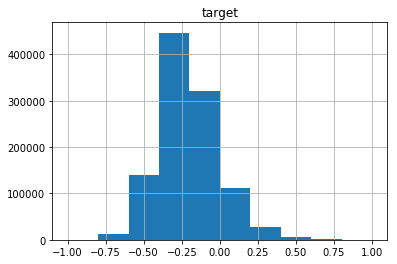

In [24]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

train_set["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train_set["target"] = target_scaler.fit_transform(train_set.target.reshape(-1,1))
pd.DataFrame(train_set.target).hist()
plt.show()

### どうする？
+ Price は外れ値があったので、外れ値分析して抜くか。多分、上位と下位5パーセントを平準化（つまり、上５パーセントの点をすべて、5パーセント点と同じ値にするなど。
+ 他の値をStanderizationしてやるか。
+ カテゴリーデータに対する分析手法ってどんなのがあるか調べる。
+ hierachy データに対するNeural network 的な手法って何があるの？
+ とりあえず、かなりシンプルなNeural Networkを実装してみて、これのPredictionの効果を見てやろうか。
+ ただ、データセットを大きくするだけじゃなくて、関係ない変数は、OLSとかでも、推定量の分散を上げたりいろいろよくないので、これを調べる必要がある。
+ 上記では、データを正規化するまえにSVDしているが、これは正規化（少なくとも、平均を０に調整）してから行うべきでは？

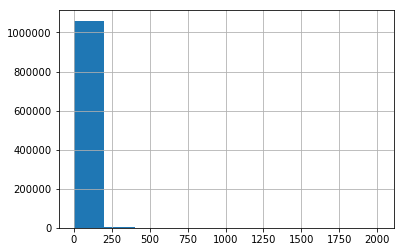

In [25]:
train_set['price'].hist()
plt.show()

+ かなりLongTailなので、上限0.1%以上を、上限0.1%点で置き換えることにする。

In [36]:
train_set

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,...,svd_name_31,svd_name_32,svd_name_33,svd_name_34,svd_name_35,svd_name_36,svd_name_37,svd_name_38,svd_name_39,target
900002,900002,New! PINK Lanyard,1,Women/Women's Accessories/Wallets,4504,20.0,1,Brand new with tag Price is for 1 LANYARD Perf...,9,110,...,0.006071,0.066072,0.107573,-0.008638,-0.046072,-0.046648,0.000896,-0.003746,-0.002640,-0.199430
502231,502231,VS Pink water bottle,1,Sports & Outdoors/Exercise/Fitness accessories,4788,13.0,0,VS metal water bottle brand new,7,37,...,-0.000970,0.000768,-0.044717,0.004262,0.020479,0.017430,-0.003050,0.006472,0.014475,-0.306049
1342662,1342662,VS Pink Robe,1,Beauty/Bath & Body/Bathing Accessories,4504,26.0,0,"Size M/L, BNWT. Mauve color with black polka d...",0,9,...,0.001061,0.001990,-0.056826,0.005077,0.025414,0.022969,-0.004703,0.007056,0.017366,-0.133346
699388,699388,Limited edition VS PINK Fern Crew Sz L,2,Women/Sweaters/Crewneck,3221,32.0,0,Brand new never worn limited edition crew. Jus...,9,96,...,0.003147,-0.002831,-0.036153,0.001255,-0.003780,0.032688,0.002874,0.002755,0.034651,-0.080579
1429801,1429801,Rue 21 flannel,1,Women/Tops & Blouses/Button Down Shirt,4799,10.0,1,New with tags Paid [rm] Size xs,9,103,...,0.013034,-0.006835,-0.004493,-0.000615,0.003001,-0.010685,0.007083,-0.006472,-0.023239,-0.369464
942010,942010,1 keychain 1 pairs pink brand new socks,1,Women/Athletic Apparel/Socks,4788,8.0,1,na,9,5,...,0.002734,0.045890,0.068109,-0.008233,-0.024999,-0.022695,0.007177,-0.003966,0.003613,-0.422231
1345456,1345456,New FreeShip Eyeliner Gel!,1,Beauty/Makeup/Eyes,4788,9.0,1,Gel Eyeliner Hurryyy!! Last one left. Brand Ne...,0,63,...,-0.007535,0.005082,0.000003,-0.001305,0.007235,-0.002013,-0.004745,0.000898,0.001342,-0.394526
1404759,1404759,Diamond black Hoodie,3,Men/Sweats & Hoodies/Hoodie,1253,20.0,0,Size small in woman's perfect condition flash ...,5,97,...,-0.117583,-0.176929,-0.031289,0.004649,0.077493,-0.061676,-0.023507,0.011970,0.036504,-0.199430
1423041,1423041,Men's baseball cut off,3,Men/Tops/Tank,4788,6.0,1,Size xl yankees men's cut off sleeve shirt,5,102,...,0.018410,0.148800,-0.060913,-0.002217,-0.200505,-0.021302,0.130665,-0.029606,-0.099510,-0.488315
862981,862981,Puma GIRLS Socks,1,Women/Athletic Apparel/Socks,3228,7.0,1,These are KIDS GIRLS puma socks! Size 7-8.5!,9,5,...,0.002010,-0.034159,-0.013132,-0.001267,0.002556,-0.005625,-0.018254,0.001838,0.002728,-0.453202


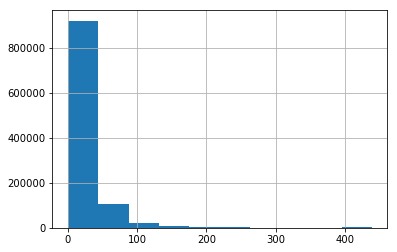

In [41]:
upper001 = train_set['price'].quantile(q = 0.999)
#lower05 = sorted_train_set['price'].quantile(q = 0.05)
outliers = (train_set['price'] > upper001)
test = train_set['price'].mask(outliers, upper001)
test.hist()
plt.show()

In [42]:
test

900002     20.0
502231     13.0
1342662    26.0
699388     32.0
1429801    10.0
942010      8.0
1345456     9.0
1404759    20.0
1423041     6.0
862981      7.0
68836      12.0
1189795     3.0
216579     23.0
413435     23.0
1106959     8.0
102581     34.0
1154106     9.0
779525     25.0
100947     35.0
637456     40.0
661674     36.0
495181     10.0
736111     12.0
1263530    30.0
1299653    11.0
1058091    49.0
466047     26.0
520943     14.0
624294     10.0
895396     16.0
           ... 
208137     38.0
497468     24.0
1127982    12.0
5758       15.0
695611      8.0
871304     15.0
1461394    32.0
1268003    51.0
933279     10.0
648966     11.0
1381497    55.0
813045     56.0
569728     10.0
397260     30.0
1261450    10.0
1117317     7.0
1148153    26.0
639239     15.0
818696     19.0
218704      7.0
1437311    13.0
770424     14.0
616348     49.0
1074840    13.0
1188250    10.0
1193532    21.0
1211802    10.0
745617     11.0
999846     19.0
827892     34.0
Name: price, Length: 106

In [44]:
y_reg_cut = np.log(test.values + 1)
lin_reg = LinearRegression()
lin_reg.fit(X_reg,y_reg_cut)
some_data = X_reg[:5]
some_labels = y_reg_cut[:5]

print("Predictions:\t", lin_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

from sklearn.metrics import mean_squared_error
mydata_predictions = lin_reg.predict(X_reg)
lin_mse = mean_squared_error(y_reg_cut, mydata_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

('Predictions:\t', array([ 3.02360084,  3.20707896,  3.12763802,  3.33191341,  2.69871722]))
('Labels:\t\t', [3.044522437723423, 2.6390573296152584, 3.2958368660043291, 3.4965075614664802, 2.3978952727983707])


0.6630621971326115

+ 若干ましになった。

### ここでXのデータを見ると、それぞれ尺度がばらばらである。これはOLSだと大丈夫っぽいが、勾配を用いて学習する時には、よくない。
+ ここで一応すべてのカテゴリーを正規化しておくことにする。

In [57]:
np.mean(X_reg['svd_name_10'])

-0.0032912712262907896

+ 上記のように、SVDで変換した後って、平均は0に調整されてるのかな？？？
+ 多分調整されている！本質的に、共分散行列はセンタリングしたデータだろうが、そうでなかろうが、変化しないので、センタリングは主成分分析の結果に影響を及ぼさないことはわかる。つまり、センタリングしたデータ（つまりデータの平均０）の時に得られた変換（もちろん平均は0) と、センタリングしない場合に得られた変換は同じものなので、センタリングしない場合でも、平均は0になっている。
+ https://www.quora.com/Why-is-it-beneficial-to-center-and-normalize-the-data-before-running-Principal-Component-Analysis-on-it
+ PCAと違い、SVDは多分センタリングの効果が及ぼす。https://stats.stackexchange.com/questions/189822/how-does-centering-make-a-difference-in-pca-for-svd-and-eigen-decomposition

+ センタリングしたデータには、SVDもPCAも同じ効果っぽいね。
+ そして、なんか各属性のScaleも影響するっぽいので、基本的に、平均は0そして、分散も0に正規化してから、PCAした方がよさそう。とにかくこれは間違いないだろう。

In [59]:
X_reg

,item_condition_id,brand_name,shipping,cat_1,cat_2,cat_3,cat_4,cat_5,svd_item_0,svd_item_1,...,svd_name_30,svd_name_31,svd_name_32,svd_name_33,svd_name_34,svd_name_35,svd_name_36,svd_name_37,svd_name_38,svd_name_39
900002,1,4504,1,9,110,831,6,2,2.939411e-06,0.175018,...,-0.058638,0.006071,0.066072,0.107573,-0.008638,-0.046072,-0.046648,0.000896,-0.003746,-0.002640
502231,1,4788,0,7,37,314,6,2,2.149811e-06,0.204305,...,0.034147,-0.000970,0.000768,-0.044717,0.004262,0.020479,0.017430,-0.003050,0.006472,0.014475
1342662,1,4504,0,0,9,60,6,2,7.970509e-07,0.091779,...,0.039615,0.001061,0.001990,-0.056826,0.005077,0.025414,0.022969,-0.004703,0.007056,0.017366
699388,2,3221,0,9,96,225,6,2,3.058477e-06,0.265761,...,0.033463,0.003147,-0.002831,-0.036153,0.001255,-0.003780,0.032688,0.002874,0.002755,0.034651
1429801,1,4799,1,9,103,132,6,2,3.001991e-06,0.318618,...,-0.003429,0.013034,-0.006835,-0.004493,-0.000615,0.003001,-0.010685,0.007083,-0.006472,-0.023239
942010,1,4788,1,9,5,704,6,2,1.000000e+00,-0.000012,...,-0.036191,0.002734,0.045890,0.068109,-0.008233,-0.024999,-0.022695,0.007177,-0.003966,0.003613
1345456,1,4788,1,0,63,292,6,2,3.956609e-06,0.211867,...,-0.006291,-0.007535,0.005082,0.000003,-0.001305,0.007235,-0.002013,-0.004745,0.000898,0.001342
1404759,3,1253,0,5,97,406,6,2,1.600674e-06,0.160449,...,-0.042841,-0.117583,-0.176929,-0.031289,0.004649,0.077493,-0.061676,-0.023507,0.011970,0.036504
1423041,3,4788,1,5,102,753,6,2,6.633018e-07,0.092358,...,0.083251,0.018410,0.148800,-0.060913,-0.002217,-0.200505,-0.021302,0.130665,-0.029606,-0.099510
862981,1,3228,1,9,5,704,6,2,7.098577e-07,0.073320,...,0.023412,0.002010,-0.034159,-0.013132,-0.001267,0.002556,-0.005625,-0.018254,0.001838,0.002728


In [87]:
from sklearn import preprocessing
X_scaled = train_set.drop(['price','train_id','name','category_name','item_description','target'], axis=1)
X_scaled = preprocessing.scale(X_scaled)
x_reg_sd = pd.DataFrame(X_scaled)
x_reg_sd.columns = standerdized_train.columns
lin_reg = LinearRegression()
lin_reg.fit(x_reg_sd,y_reg_cut)
some_data = x_reg_sd[:5]
some_labels = y_reg_cut[:5]

print("Predictions:\t", lin_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

from sklearn.metrics import mean_squared_error
mydata_predictions = lin_reg.predict(x_reg_sd)
lin_mse = mean_squared_error(y_reg_cut, mydata_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

('Predictions:\t', array([ 3.02360084,  3.20707896,  3.12763802,  3.33191341,  2.69871722]))
('Labels:\t\t', [3.044522437723423, 2.6390573296152584, 3.2958368660043291, 3.4965075614664802, 2.3978952727983707])


0.66306219713261161

+ OLS推定量は正規化してももちろん値は変わらない。

In [89]:
x_reg_sd

,item_condition_id,brand_name,shipping,cat_1,cat_2,cat_3,cat_4,cat_5,svd_item_0,svd_item_1,...,svd_name_30,svd_name_31,svd_name_32,svd_name_33,svd_name_34,svd_name_35,svd_name_36,svd_name_37,svd_name_38,svd_name_39
0,-1.004540,0.645039,1.111805,0.940283,1.294562,1.570634,0.040935,0.042503,-0.242993,0.651530,...,-1.215281,0.076605,1.446719,2.235777,-0.175730,-0.955191,-1.036196,-0.072051,-0.119567,-0.043312
1,-1.004540,0.834953,-0.899438,0.375121,-0.772995,-0.496385,0.040935,0.042503,-0.242996,0.945533,...,0.699341,-0.070341,0.080911,-0.974141,0.095289,0.460215,0.336221,-0.158041,0.103239,0.330638
2,-1.004540,0.645039,-0.899438,-1.602947,-1.566030,-1.511903,0.040935,0.042503,-0.243002,-0.184090,...,0.812174,-0.027955,0.106463,-1.229384,0.112413,0.565175,0.454842,-0.194065,0.115970,0.393807
3,0.102806,-0.212921,-0.899438,0.940283,0.898044,-0.852216,0.040935,0.042503,-0.242992,1.562468,...,0.685229,0.015576,0.005625,-0.793627,0.032118,-0.055721,0.663008,-0.028944,0.022181,0.771494
4,-1.004540,0.842309,1.111805,0.940283,1.096303,-1.224040,0.040935,0.042503,-0.242993,2.093085,...,-0.076052,0.221932,-0.078111,-0.126317,-0.007159,0.088489,-0.265939,0.062767,-0.179008,-0.493416
5,-1.004540,0.834953,1.111805,0.940283,-1.679321,1.062875,0.040935,0.042503,4.115448,-1.105552,...,-0.752093,0.006965,1.024612,1.403958,-0.167222,-0.507012,-0.523174,0.064810,-0.124352,0.093306
6,-1.004540,0.834953,1.111805,-1.602947,-0.036605,-0.584343,0.040935,0.042503,-0.242988,1.021441,...,-0.135109,-0.207346,0.171131,-0.031556,-0.021670,0.178546,-0.080223,-0.194968,-0.018305,0.043679
7,1.210152,-1.528951,-0.899438,-0.190041,0.926367,-0.128560,0.040935,0.042503,-0.242999,0.505269,...,-0.889317,-2.504096,-3.635552,-0.691105,0.103430,1.672795,-1.358075,-0.603819,0.223114,0.811990
8,1.210152,0.834953,1.111805,-0.190041,1.067980,1.258782,0.040935,0.042503,-0.243003,-0.178273,...,1.712607,0.334130,3.176939,-1.315507,-0.040825,-4.239666,-0.493353,2.755729,-0.683437,-2.159972
9,-1.004540,-0.208240,1.111805,0.940283,-1.679321,1.062875,0.040935,0.042503,-0.243003,-0.369386,...,0.477817,-0.008150,-0.649583,-0.308407,-0.020861,0.079031,-0.157573,-0.489359,0.002195,0.073962
